In [10]:
!pip install --user matplotlib



You are using pip version 18.1, however version 20.3b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

In [14]:
def epsilon_greedy(Q, S, epsilon):
    if random.uniform(0, 1) <= (1 - epsilon + (epsilon / len(Q[S]))):
        return np.argmax(Q[S])
    
    return random.randrange(len(Q[S]))
                            

In [15]:
def sarsa(env, gamma, number_of_episodes=500, step_size=0.1, epsilon=0.1):
    Q = np.zeros((env.nS, env.nA))
    sum_of_steps = []
    for episode in range(number_of_episodes):
        S = env.reset()
        done = False
        step_count = 0
        A = epsilon_greedy(Q, S, epsilon)
        
        while not done:
            S_next, reward, done, info = env.step(A)
            A_next = epsilon_greedy(Q, S_next, epsilon)
            step_count += 1
            
            if done:
                Q[S,A] = 0
                sum_of_steps.append(step_count)
            else:
                Q[S,A] = Q[S,A] + step_size * (reward + gamma * (Q[S_next,A_next] - Q[S,A]))
            
            S = S_next
            A = A_next
            
    plt.plot(range(number_of_episodes), sum_of_steps)
    plt.ylabel('Total number of steps')
    plt.ylabel('Episode')
    plt.show()
    return Q

In [16]:
def expected_sum(Q, S, epsilon):
    sum = 0
    number_of_actions = len(Q[S])
    A_optimal = np.argmax(Q[S])
    for A in range(number_of_actions):
        if A == A_optimal:
            sum += (1 - epsilon + epsilon / number_of_actions) * Q[S, A]
        else:
            sum += (epsilon / number_of_actions) * Q[S, A]
    return sum

In [18]:
def expected_sarsa(env, gamma, number_of_episodes=500, step_size=0.1, epsilon=0.1):
    Q = np.zeros((env.nS, env.nA))
    sum_of_steps = []
    for episode in range(number_of_episodes):
        S = env.reset()
        done = False
        step_count = 0
        A = epsilon_greedy(Q, S, epsilon)
        
        while not done:
            S_next, reward, done, info = env.step(A)
            A_next = epsilon_greedy(Q, S_next, epsilon)
            step_count += 1
            
            if done:
                Q[S,A] = 0
                sum_of_steps.append(step_count)
            else:
                Q[S,A] = Q[S,A] + step_size * (reward + gamma * (expected_sum(Q, S_next, epsilon) - Q[S,A]))
            
            S = S_next
            A = A_next
            
    plt.plot(range(number_of_episodes), sum_of_steps)
    plt.ylabel('Total number of steps')
    plt.ylabel('Episode')
    plt.show()
    return Q

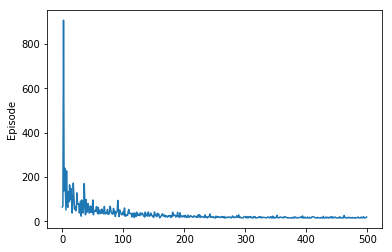

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Total reward:  -15 in steps: 15


In [23]:

env = gym.make('CliffWalking-v0')
env.reset()

Q = expected_sarsa(env, 1.0, 500, epsilon=0.1, step_size= 0.1)

env.reset()
done = False
steps = 0
state = env.s
total_reward = 0
env.render()
while not done:
    state, reward, done, info = env.step(np.argmax(Q[state]))
    total_reward += reward
    steps += 1
    #env.render()

print('Total reward: ', total_reward, 'in steps:', steps)


In [ ]:
env = gym.make('FrozenLake-v0')
env.reset()

Q = expected_sarsa(env, 1.0, 500)

env.reset()
done = False
steps = 0
state = env.s
total_reward = 0
#env.render()
while not done:
    state, reward, done, info = env.step(np.argmax(Q[state]))
    total_reward += reward
    steps += 1
    #env.render()

print('Total reward: ', total_reward, 'in steps:', steps)